# MAP Deblurer - grayscale

In [4]:
%load_ext autoreload
%autoreload 2

from utils import *

%matplotlib inline
import matplotlib.pyplot as plt

import scipy.io as io
#%env CUDA_VISIBLE_DEVICES=1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MAP Denoiser

### Train MAP Denoiser
(skip if you want to use the provided model) 

In [ ]:
from MAPdenoiser import MAPdenoiser
DAE = MAPdenoiser(stddev=7.0/255.0, channels=1)

In [ ]:
DAE.train(epoch = 50, batch_size = 128, lr = 0.001, phase = "train",
          ckpt_dir = './models/map_gray', sample_dir ='./sample', test_dir ='./test',
          dataset_path = './data/datasets/img_clean_pats.npy', eval_set ='Set12', test_set ='Set12',
          eval_every_epoch=1)

In [ ]:
DAE.freeze_graph(ckpt_dir = './models/map_gray')

### Test MAP Denoiser
(on noise-less image)

['clean_image=>Placeholder', 'denoised=>Identity']
PSNR noisy: inf
Iter: 0 PSNR noisy: 42.965678756956436
Iter: 1 PSNR noisy: 38.36624829478359
Iter: 2 PSNR noisy: 36.12667549794439
Iter: 3 PSNR noisy: 34.75513088993563
Iter: 4 PSNR noisy: 33.80269768369666
Iter: 5 PSNR noisy: 33.08564815561599
Iter: 6 PSNR noisy: 32.514791987281136
Iter: 7 PSNR noisy: 32.04000192656181
Iter: 8 PSNR noisy: 31.631030629540025
Iter: 9 PSNR noisy: 31.270655460824944
Iter: 10 PSNR noisy: 30.947996286468364
Iter: 11 PSNR noisy: 30.6551428552895
Iter: 12 PSNR noisy: 30.386109639207234
Iter: 13 PSNR noisy: 30.13645204010826
Iter: 14 PSNR noisy: 29.90321071893049
Iter: 15 PSNR noisy: 29.68424353771661
Iter: 16 PSNR noisy: 29.477452870334385


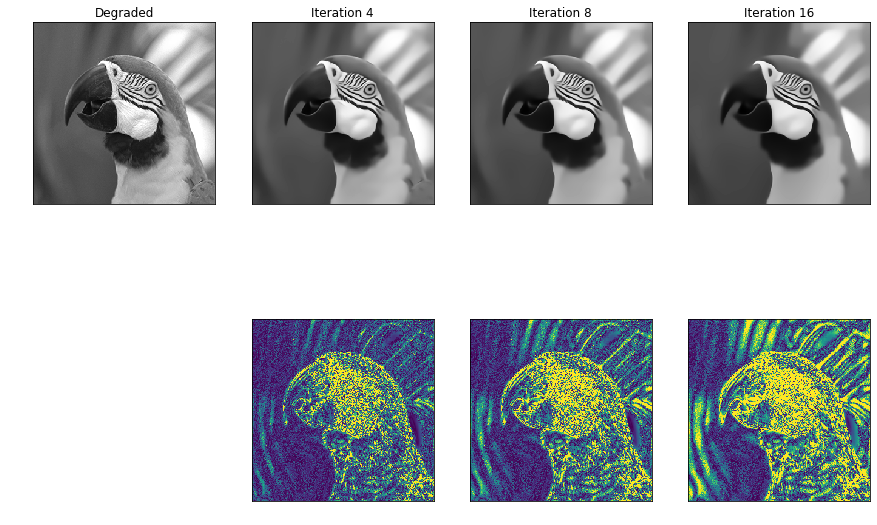

In [18]:
from MAPdenoiser import frozenMAPdenoiser
denoiser = frozenMAPdenoiser(channels=1, ckpt_dir = './models/map_gray')

gt = np.array(Image.open('./data/images/kodim23.png').convert('L'), dtype='float32')[120:420,20:320,None]

noise = np.random.normal(0.0, 7.0, gt.shape).astype(np.float32)
degraded = gt.copy() # + noise

print("PSNR noisy:", cal_psnr(degraded, gt))

plt.rc(('xtick','ytick'),color=(1,1,1,0))
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(241)
plt.imshow(np.squeeze(np.clip(degraded,0,255)), cmap="gray")
plt.title('Degraded')

res = degraded.copy()
j = 0
for i in range(17):
    res = denoiser.denoise(res/255.0)*255
    print("Iter:", i, "PSNR noisy:", cal_psnr(res, gt))
    if i == 4 or i == 8 or i == 16:
        ax = plt.subplot(242+j)
        plt.imshow(np.squeeze(np.clip(res / 255 ,0,1)), cmap="gray")
        plt.title('Iteration ' +str(i))
        ax = plt.subplot(246+j)
        plt.imshow(np.squeeze(np.clip(np.abs(res-degraded)/10.0,0,1)))
        #plt.title('Residual at iteration ' + str(i))
        j = j + 1

## Deblurring

### Test image + test kernel

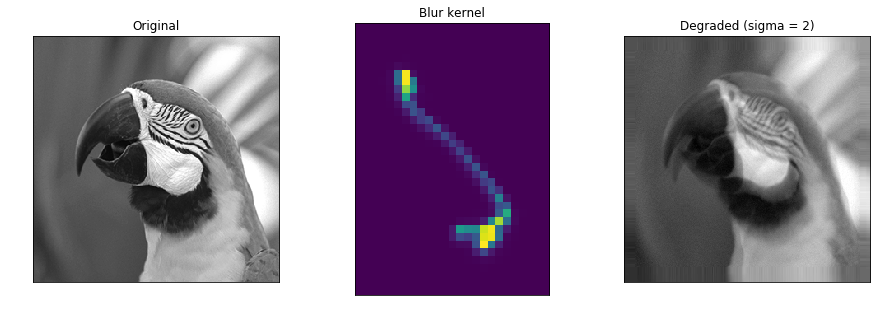

In [21]:
sigma_d = 255 * .01

kernel = io.loadmat('./data/kernels.mat')['kernels'][0,0]
kernel = kernel / np.sum(kernel[:])
fig = plt.figure(figsize=(15, 5))
plt.subplot(132)
plt.imshow(kernel)
plt.title("Blur kernel")

gt = np.array(Image.open('./data/images/kodim23.png').convert('L'), dtype='float32')
gt = gt[120:420,20:320,None]
plt.subplot(131)
plt.title("Original")
plt.imshow(np.squeeze(gt), cmap="gray")

initial = real_blur_and_noise(gt, kernel, sigma_d) 

img_degraded = Image.fromarray(np.clip(np.squeeze(initial), 0, 255).astype(dtype=np.uint8))
#img_degraded.save("data/degraded.png","png")

plt.subplot(133)
plt.imshow(np.squeeze(img_degraded), cmap="gray")
plt.title("Degraded (sigma = %d)" % sigma_d)
plt.show()

### Optimization

Iter. 5: PSNR is:29.645649232343825, iteration finished in 0.027428865432739258 seconds
Iter. 10: PSNR is:31.088900361663192, iteration finished in 0.022366046905517578 seconds
Iter. 15: PSNR is:31.60176442984559, iteration finished in 0.01365518569946289 seconds
Iter. 20: PSNR is:31.829346763408687, iteration finished in 0.013879776000976562 seconds
Iter. 25: PSNR is:31.944135217693322, iteration finished in 0.0128326416015625 seconds
Iter. 30: PSNR is:32.01399654422387, iteration finished in 0.012835264205932617 seconds
Iter. 35: PSNR is:32.059054022532905, iteration finished in 0.022902965545654297 seconds
Iter. 40: PSNR is:32.09036147644315, iteration finished in 0.012731790542602539 seconds
Iter. 45: PSNR is:32.11730658267568, iteration finished in 0.012780427932739258 seconds
Iter. 50: PSNR is:32.13883904448348, iteration finished in 0.012705087661743164 seconds
Iter. 55: PSNR is:32.15463529524003, iteration finished in 0.012778759002685547 seconds
Iter. 60: PSNR is:32.1712833304

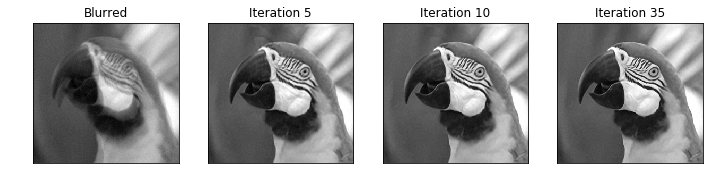

In [54]:
from fastMAPdeblurer import fastMAPDeblurer

sigma_dae = 7
rho = 1 / (sigma_dae**2+10)
# small pertrubation to the rho helps the convergence (default: 1 / (sigma_dae**2))

deblurer = fastMAPDeblurer(rho, sigma_d, gt.shape,
                            kernel_shape=kernel.shape,
                            denoiser = './models/map_gray/optimizedMAPdenoiser.pb')
est = deblurer.optimize(initial, kernel, gt, nr_iters=75, test_iter=5, plot=True)
#est_psnr = computePSNR(gt, est, kernel.shape[0] // 2, kernel.shape[1] // 2)